# Mode-1 internal wave reflection

This example simulates the propagation of a mode-1 internal wave
using the `ClimateMachine.Ocean` subcomponent to solve the hydrostatic
Boussinesq equations.

First we `ClimateMachine.init()`.

In [1]:
using ClimateMachine

ClimateMachine.init()

# Domain setup

We formulate a non-dimension problem in a Cartesian domain with oceanic anisotropy,

In [2]:
using ClimateMachine.Ocean.Domains

domain = RectangularDomain(
    Ne = (32, 1, 4),
    Np = 4,
    x = (-128, 128),
    y = (-128, 128),
    z = (-1, 0),
    periodicity = (false, false, false),
)

RectangularDomain{Float64}
    Np = 4, Ne = (x = 32, y = 1, z = 4)
    L = (x = 256.0, y = 256.0, z = 1.0)


# Parameters

We choose parameters appropriate for a hydrostatic internal wave,

Non-dimensional internal wave parameters

In [3]:
f = 1  # Coriolis
N = 10 # Buoyancy frequency

10

Note that the validity of the hydrostatic approximation requires
small aspect ratio motions with ``k / m \\ll 1``.
The hydrostatic dispersion relation for inertia-gravity waves then implies that

In [4]:
λ = 8      # horizontal wave-length
k = 2π / λ # horizontal wavenumber
m = π

ω² = f^2 + N^2 * k^2 / m^2 # and

ω = √(ω²)

2.692582403567252

# Internal wave initial condition

We impose modest gravitational acceleration to render time-stepping feasible,

In [5]:
using CLIMAParameters: AbstractEarthParameterSet, Planet
struct NonDimensionalParameters <: AbstractEarthParameterSet end

Planet.grav(::NonDimensionalParameters) = 256.0

we'd like to use `θ` as a buoyancy variable, which requires
setting the thermal expansion coefficient ``αᵀ`` to

In [6]:
g = Planet.grav(NonDimensionalParameters())

αᵀ = 1 / g

0.00390625

We then use the "polarization relations" for vertically-standing, horizontally-
propagating hydrostatic internal waves to initialze two wave packets.
The hydrostatic polarization relations require

$$
\begin{gather}
(∂_t^2 + f^2) u = - ∂_x ∂_t p
∂_t v = - f u
b = ∂_z p
\end{gather}
$$

Thus given ``p = \cos (k x - ω t) \cos (m z)``, we find

In [7]:
δ = domain.L.x / 15
a(x) = 1e-6 * exp(-x^2 / 2 * δ^2)

ũ(x, z, t) = +a(x) * ω * sin(k * x - ω * t) * cos(m * z)
ṽ(x, z, t) = -a(x) * f * cos(k * x - ω * t) * cos(m * z)
θ̃(x, z, t) = -a(x) * m / k * (ω^2 - f^2) * sin(k * x - ω * t) * sin(m * z)

uᵢ(x, y, z) = ũ(x, z, 0)
vᵢ(x, y, z) = ṽ(x, z, 0)
θᵢ(x, y, z) = θ̃(x, z, 0) + N^2 * z

using ClimateMachine.Ocean.OceanProblems: InitialConditions

initial_conditions = InitialConditions(u = uᵢ, v = vᵢ, θ = θᵢ)

ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(Main.##351.uᵢ),typeof(Main.##351.vᵢ),typeof(Main.##351.θᵢ),typeof(ClimateMachine.Ocean.OceanProblems.resting)}(Main.##351.uᵢ, Main.##351.vᵢ, Main.##351.θᵢ, ClimateMachine.Ocean.OceanProblems.resting)

# Model configuration

We choose a time-step that resolves the gravity wave phase speed,

In [8]:
time_step = 0.005 # close to Δx / c = 0.5 * 1/16, where Δx is nominal resolution

0.005

and build a model with a smidgeon of viscosity and diffusion,

In [9]:
using ClimateMachine.Ocean: HydrostaticBoussinesqSuperModel

model = HydrostaticBoussinesqSuperModel(
    domain = domain,
    time_step = time_step,
    initial_conditions = initial_conditions,
    parameters = NonDimensionalParameters(),
    turbulence_closure = (νʰ = 1e-6, νᶻ = 1e-6, κʰ = 1e-6, κᶻ = 1e-6),
    coriolis = (f₀ = f, β = 0),
    buoyancy = (αᵀ = αᵀ,),
    boundary_tags = ((1, 1), (1, 1), (1, 2)),
)

┌ Info: Initializing 
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/709/climatemachine-docs/src/Driver/solver_configs.jl:167


ClimateMachine.Ocean.SuperModels.HydrostaticBoussinesqSuperModel{ClimateMachine.Ocean.Domains.RectangularDomain{Float64},ClimateMachine.Mesh.Grids.DiscontinuousSpectralElementGrid{Float64,3,(4, 4, 4),125,Array,Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}},Array{Float64,3},Array{Float64,4},Array{Int64,1},Array{Int64,2},Array{Int64,3},ClimateMachine.Mesh.Topologies.StackedBrickTopology{3,Float64,2},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}}},ClimateMachine.Ocean.HydrostaticBoussinesq.HydrostaticBoussinesqModel{ClimateMachine.Ocean.Uncoupled,Main.##351.NonDimensionalParameters,ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(Main.##351.uᵢ),typeof(Main.##351.vᵢ),typeof(Main.##351.θᵢ),typeof(ClimateMachine.Ocean.OceanProblems.resting)},Tuple{ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},

# Fetching data for an animation

To animate the `ClimateMachine.Ocean` solution, we assemble and
cache the horizontal velocity ``u`` at periodic intervals:

In [10]:
using ClimateMachine.Ocean: current_time
using ClimateMachine.Ocean.Fields: assemble
using ClimateMachine.GenericCallbacks: EveryXSimulationTime

fetched_states = []
fetch_every = 0.2 * 2π / ω # time

data_fetcher = EveryXSimulationTime(fetch_every) do
    push!(
        fetched_states,
        (
            u = assemble(model.fields.u.elements),
            θ = assemble(model.fields.θ.elements),
            η = assemble(model.fields.η.elements),
            time = current_time(model),
        ),
    )
    return nothing
end

ClimateMachine.GenericCallbacks.EveryXSimulationTime(Main.##351.var"#1#2"(), 0.46670328817831874, 0)

We also build a callback to log the progress of our simulation,

In [11]:
using Printf
using ClimateMachine.GenericCallbacks: EveryXSimulationSteps
using ClimateMachine.Ocean: current_time, current_step, Δt

print_every = 100 # iterations
wall_clock = [time_ns()]

tiny_progress_printer = EveryXSimulationSteps(print_every) do

    @info(@sprintf(
        "Steps: %d, time: %.2f, Δt: %.2f, max(|u|): %.2e, elapsed time: %.2f secs",
        current_step(model),
        current_time(model),
        Δt(model),
        maximum(abs, model.fields.u),
        1e-9 * (time_ns() - wall_clock[1])
    ))

    wall_clock[1] = time_ns()
end

ClimateMachine.GenericCallbacks.EveryXSimulationSteps(Main.##351.var"#3#4"(), 100, 0)

# Running the simulation and animating the results

We're ready to launch.

In [12]:
model.solver_configuration.timeend = 6 * 2π / ω
# model.solver.dt = 0.05 # make this work

@info """ Simulating a hydrostatic Gaussian wave packet with parameters

    f (Coriolis parameter):       $f
    N (buoyancy frequency):       $N
    Internal wave frequency:      $(abs(ω))
    Surface wave frequency:       $(k * sqrt(g * domain.L.z))
    Surface wave group velocity:  $(sqrt(g * domain.L.z))
    Internal wave group velocity: $(N^2 * k / (ω * m))
    Domain width:                 $(domain.L.x)
    Domain height:                $(domain.L.z)

"""

result = ClimateMachine.invoke!(
    model.solver_configuration;
    user_callbacks = [tiny_progress_printer, data_fetcher],
)

┌ Info:  Simulating a hydrostatic Gaussian wave packet with parameters
│ 
│     f (Coriolis parameter):       1
│     N (buoyancy frequency):       10
│     Internal wave frequency:      2.692582403567252
│     Surface wave frequency:       12.566370614359172
│     Surface wave group velocity:  16.0
│     Internal wave group velocity: 9.284766908852594
│     Domain width:                 256.0
│     Domain height:                1.0
│ 
└ @ Main.##351 string:4
┌ Info: Starting 
│     dt              = 5.00000e-03
│     timeend         =    14.00
│     number of steps = 1
│     norm(Q)         = 1.4780166891254394e+04
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/709/climatemachine-docs/src/Driver/Driver.jl:754
┌ Info: Steps: 100, time: 0.50, Δt: 0.01, max(|u|): 2.54e-07, elapsed time: 35.41 secs
└ @ Main.##351 string:10
┌ Info: Steps: 200, time: 1.00, Δt: 0.01, max(|u|): 1.54e-07, elapsed time: 1.76 secs
└ @ Main.##351 string:10
┌ Info: Steps: 300, time: 1.50, Δt: 0.01

0.9999575475529562

# Animating the result

We first analye the results to generate plotting limits and contour levels

In [13]:
ηmax = maximum([maximum(abs, state.η.data) for state in fetched_states])
umax = maximum([maximum(abs, state.u.data) for state in fetched_states])

ηlim = (-ηmax, ηmax)
ulim = (-umax, umax)
ulevels = range(ulim[1], ulim[2], length = 31)

-2.2110987101884194e-7:1.4740658067922796e-8:2.2110987101884194e-7

and then animate both fields in a loop,

┌ Info: Plotting frame 1 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 2 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 3 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 4 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 5 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 6 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 7 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 8 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 9 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 10 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 11 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 12 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 13 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 14 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 15 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 16 of 29...
└ @ Main.##351 string:4
┌ Info: Plotting frame 17 of 29...
└ @ Main.##351 string:4
┌ Info

Plots.AnimatedGif("/central/scratch/climaci/climatemachine-docs/709/climatemachine-docs/docs/src/generated/Ocean/internal_wave.gif")
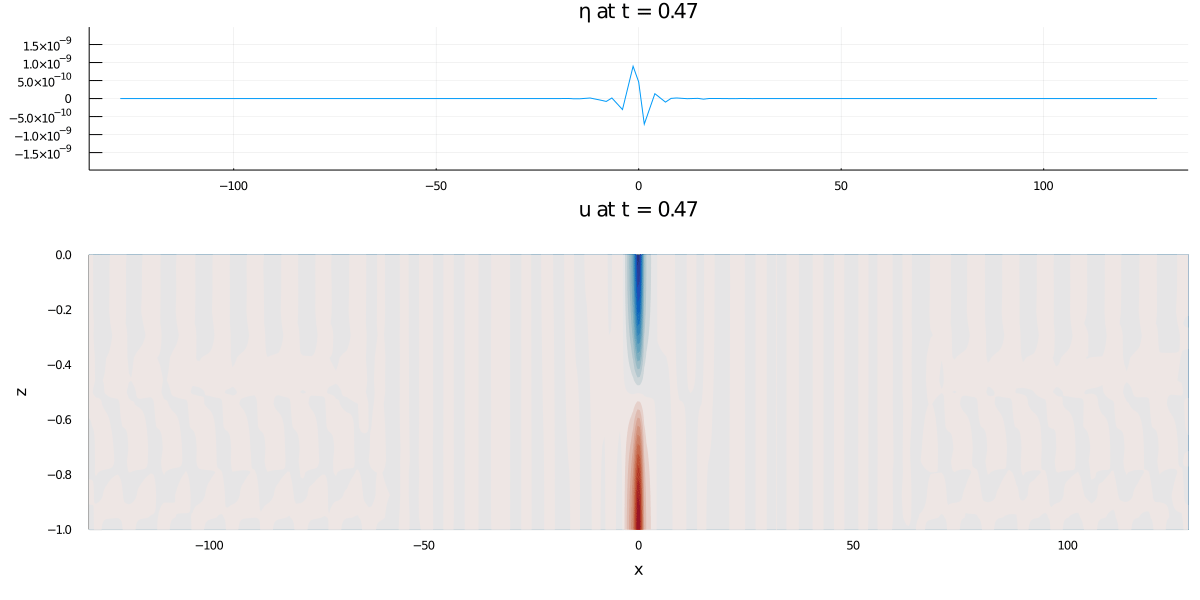

In [14]:
using Plots

animation = @animate for (i, state) in enumerate(fetched_states)
    @info "Plotting frame $i of $(length(fetched_states))..."

    η_plot = plot(
        state.u.x[:, 1, 1],
        state.η.data[:, 1, 1],
        ylim = ηlim,
        label = nothing,
        title = @sprintf("η at t = %.2f", state.time),
    )

    u_plot = contourf(
        state.u.x[:, 1, 1],
        state.u.z[1, 1, :],
        clamp.(state.u.data[:, 1, :], ulim[1], ulim[2])';
        aspectratio = 64,
        linewidth = 0,
        xlim = domain.x,
        ylim = domain.z,
        xlabel = "x",
        ylabel = "z",
        color = :balance,
        colorbar = false,
        clim = ulim,
        levels = ulevels,
        title = @sprintf("u at t = %.2f", state.time),
    )

    plot(
        η_plot,
        u_plot,
        layout = Plots.grid(2, 1, heights = (0.3, 0.7)),
        link = :x,
        size = (1200, 600),
    )
end

gif(animation, "internal_wave.gif", fps = 8) # hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*